In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

alpha = 1 # proximal term coefficient
history = 1
res_type="primal"

num_agents = num_packages = 200
num_fcs = 50

# num_agents = num_packages = 40
# num_fcs = 9

filename = "ncvx_ap_N%d_%.2f_n%d_m%d_H%d_%s"%(num_points, eps_sublevel, num_agents, num_fcs, history, res_type)

In [4]:
econ, A_ineq, b_ineq = mra.ap_data(num_packages, num_fcs)

In [26]:
b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [5]:
cvx_true_xp, cvx_true_xf, cvx_true_f, true_lamb, cvx_true_prob = mra.assignment_problem_milp_solution(num_packages, num_fcs, econ,  
                                                                                     integer=False)
# print(f"{cvx_true_f=} \n{cvx_true_prob.status} \n{true_lamb=} \n{cvx_true_xf=}")
print(f"{cvx_true_f=}")

cvx_true_f=-90.29596235198767


# MILP centralized solution

In [6]:
true_xp, true_xf, true_f, _, true_prob = mra.assignment_problem_milp_solution(num_packages, num_fcs, econ,  
                                                                                     integer=True, solver=cp.GUROBI, verbose=True, 
                                                                                     mipgap=0.01, timelimit=150)
print(f"{true_f=} \n{true_prob.status} \n{true_xf=}")

Set parameter Username
Set parameter LicenseID to value 2606542
Academic license - for non-commercial use only - expires 2026-01-06
Set parameter TimeLimit to value 150
Set parameter MIPGap to value 0.01
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jan 31 10:07:51 PM: Your problem has 20100 variables, 651 constraints, and 0 parameters.
(CVXPY) Jan 31 10:07:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 31 10:07:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 31 10:07:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-----------------------------------

/Users/parshakova.tanya/opt/anaconda3/envs/osbdo/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


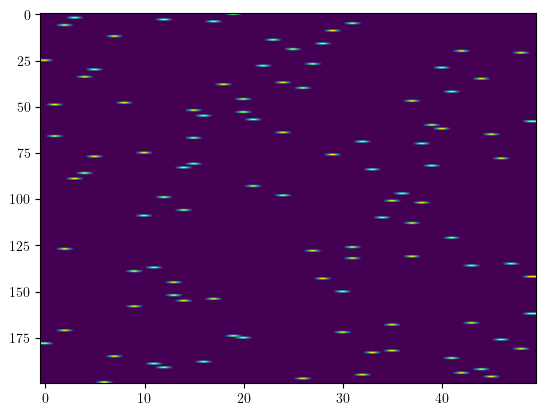

In [7]:
plt.imshow(true_xp, aspect='auto')

In [8]:
true_lamb.shape, true_xp.size + true_xf.size

((50,), 10050)

In [9]:
mra.assignment_problem_milp_solution_lamb(true_lamb, num_packages, num_fcs, econ, integer=True) 

Set parameter Username
Set parameter LicenseID to value 2606542
Academic license - for non-commercial use only - expires 2026-01-06


-90.29596327465502

In [10]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_packages):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.package_agent_query_multiple_actions(lamb_k, i, num_fcs,
                                                                                  econ, eps_sublevel=eps_sublevel, K=K,  
                                                                                  return_best=True, integer=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.package_agent_query_multiple_actions_noisy_prices(lamb_k, i, num_fcs,
                                                                                  econ, percent=percent, K=K,  
                                                                                  return_best=True, integer=True)]
 
for i in range(num_packages, num_packages+num_fcs):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions(lamb_k, i-num_packages, 
                                                                          econ, eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions_noisy_prices(lamb_k, i-num_packages, 
                                                                          econ, percent=percent, K=K, return_best=True)]


fun_obj_val = lambda x_k: mra.assignment_problem_obj_val(x_k, num_packages, num_fcs, econ, integer=False)

# Localization

In [11]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [12]:
all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=False, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            method="accpm_l2", true_f=true_f, print_freq=5, eps_lamb=1e-28,
                                                            res_type=res_type, history=history)

/Users/parshakova.tanya/Documents/projects/mra_precovery/mra/localization_prim_rec.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=1.3234E+00,  f_subopt_mra=1.2720E+00,  viol_xk=1.3706E+02, viol_mra=1.3252E+02, lamb_rel_diff=INF
epoch=5, f_subopt_xk=8.1012E-01,  f_subopt_mra=4.7125E-01,  viol_xk=2.2882E+02, viol_mra=1.0495E+02, lamb_rel_diff=6.8410E-02
epoch=10, f_subopt_xk=1.5100E-01,  f_subopt_mra=8.2716E-02,  viol_xk=8.2211E+01, viol_mra=3.0660E+01, lamb_rel_diff=6.1865E-02
epoch=15, f_subopt_xk=9.1551E-02,  f_subopt_mra=7.5418E-02,  viol_xk=7.8628E+01, viol_mra=2.8792E+01, lamb_rel_diff=5.8851E-02
epoch=20, f_subopt_xk=8.7610E-02,  f_subopt_mra=7.3827E-02,  viol_xk=7.5588E+01, viol_mra=2.6077E+01, lamb_rel_diff=5.8195E-02
epoch=25, f_subopt_xk=8.3784E-02,  f_subopt_mra=6.8130E-02,  viol_xk=6.8182E+01, viol_mra=2.4869E+01, lamb_rel_diff=5.8115E-02
epoch=30, f_subopt_xk=8.3717E-02,  f_subopt_mra=7.0848E-02,  viol_xk=7.7719E+01, viol_mra=2.3650E+01, lamb_rel_diff=5.5542E-02
epoch=35, f_subopt_xk=8.8843E-02,  f_subopt_mra=6.9962E-02,  viol_xk=6.5941E+01, viol_mra=2.4699E+01, lamb_rel_diff=5.69

In [13]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.price_localization_primal_recovery(fun_agents_eps, fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=False, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            method="accpm_l2", true_f=true_f, print_freq=5, eps_lamb=1e-28,
                                                            res_type=res_type, history=history)

epoch=0, f_subopt_xk=1.3234E+00,  f_subopt_mra=1.0474E+00,  viol_xk=1.3706E+02, viol_mra=1.0278E+02, lamb_rel_diff=INF
epoch=5, f_subopt_xk=8.1012E-01,  f_subopt_mra=6.4948E-01,  viol_xk=2.2882E+02, viol_mra=1.6164E+02, lamb_rel_diff=6.8410E-02
epoch=10, f_subopt_xk=1.5100E-01,  f_subopt_mra=3.1406E-02,  viol_xk=8.2211E+01, viol_mra=2.3473E+01, lamb_rel_diff=6.1865E-02
epoch=15, f_subopt_xk=9.1551E-02,  f_subopt_mra=1.9170E-02,  viol_xk=7.8628E+01, viol_mra=8.6894E+00, lamb_rel_diff=5.8851E-02
epoch=20, f_subopt_xk=8.7610E-02,  f_subopt_mra=9.4118E-03,  viol_xk=7.5588E+01, viol_mra=8.6374E+00, lamb_rel_diff=5.8195E-02
epoch=25, f_subopt_xk=8.3784E-02,  f_subopt_mra=3.0678E-03,  viol_xk=6.8182E+01, viol_mra=7.0406E+00, lamb_rel_diff=5.8115E-02
epoch=30, f_subopt_xk=8.3717E-02,  f_subopt_mra=1.7059E-02,  viol_xk=7.7719E+01, viol_mra=8.4177E+00, lamb_rel_diff=5.5542E-02
epoch=35, f_subopt_xk=8.8843E-02,  f_subopt_mra=8.9177E-03,  viol_xk=6.5941E+01, viol_mra=6.2541E+00, lamb_rel_diff=5.69

In [23]:
mra_xk_eps[:-num_fcs].sum(), num_packages

(102.0, 200)

In [24]:
mra_xk_noisy_y[:-num_fcs].sum(), num_packages

(102.0, 200)

In [16]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [25]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)

In [ ]:
print("sub_eps", np.array(all_results_eps["viol_primal_prec"]).size,
      "noisy_y", np.array(all_results_noisy_y["viol_primal_prec"]).size)

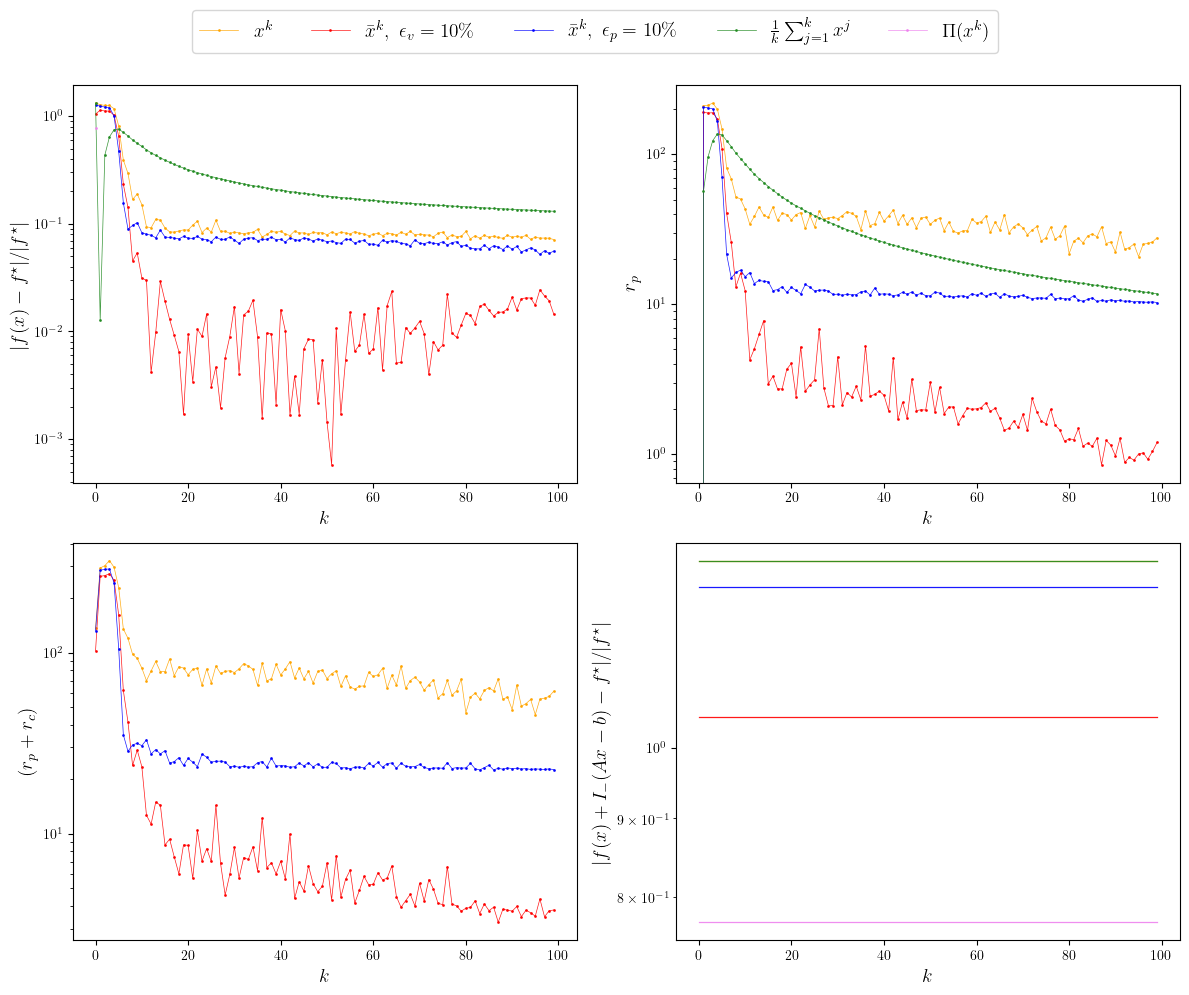

In [27]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename)